# 1 Warmup

In [46]:
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import notebook

from torch import optim

In [4]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [5]:
data = sample_data()

In [6]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, validate_data = train_test_split(train_data, test_size=0.25)

In [7]:
def p(theta, x):
    return torch.exp(theta[x]) / torch.sum(torch.exp(theta))

In [8]:
def Loss(output):
    return -torch.sum(torch.log(output))

In [9]:
class Model:
    def __init__(self, size):
        self.theta = torch.zeros(size, requires_grad=True)
        
    def forward(self, x):
        return p(self.theta, x)
    
    def parameters(self):
        return [self.theta]
    
    def __call__(self, x):
        return self.forward(x)

In [10]:
batch_size = 1000
batches = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = Model(100)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)

In [11]:
train_loss = []
validate_loss = []
        
for epoch in notebook.tqdm(range(20)):
    for batch_data in batches:
        optimizer.zero_grad()
        output = model(batch_data)
        loss = Loss(output)
        train_loss.append(loss / batch_size)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(validate_data)
        loss = Loss(output)
        validate_loss.append(loss / len(validate_data))

with torch.no_grad():
    output = model(test_data)
    loss = Loss(output)
    print("Test set loss: " + str(loss.item() / len(test_data)))



Test set loss: 4.05616552734375


In [12]:
def draw_losses(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / 20), val_loss_values, label='validate')
    plt.legend()
    plt.xlabel("iter")
    plt.ylabel("Loss")
    plt.show()

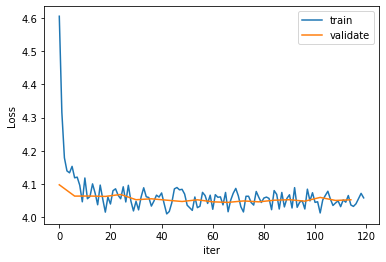

In [13]:
draw_losses(train_loss, validate_loss)

In [14]:
prob = [model(x).item() for x in np.arange(99)]
prob.append(1 - np.sum(prob))

In [15]:
print(np.sum(prob))

1.0


In [16]:
predicted_probs = model(np.arange(100)).tolist()
empirical_probs = np.zeros(100)
for x in np.random.choice(np.arange(100), size=1000, p=prob):
    empirical_probs[x] += 1
empirical_probs /= 1000

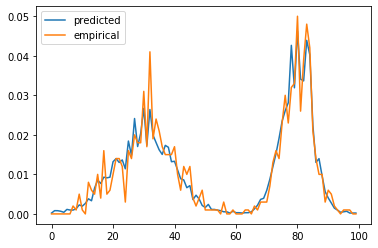

In [17]:
plt.plot(list(range(100)), predicted_probs, label='predicted')
plt.plot(list(range(100)), empirical_probs, label='empirical')
plt.legend()
plt.show()

# 2 Two-dimensional data

In [18]:
import torch.nn as nn

In [19]:
class MLPModel():
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(200, 200),
            nn.Softmax()
        )

    def forward(self, x):
        return self.model(x)
    
    def parameters(self):
        return self.model.parameters()
    
    def __call__(self, x):
        return self.forward(x)

In [20]:
class Model2D():
    def __init__(self):
        self.model_1d = Model(200)
        self.mlp_model = MLPModel()
        self.one_hot = torch.eye(200)
        
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        
        p1 = self.model_1d(x1)
        model_p = self.mlp_model(self.one_hot[x1])
        p2 = model_p[np.arange(x.shape[0]), x2]
        p = p1 * p2

        return p
    
    def parameters(self):
        return list(self.mlp_model.parameters()) + self.model_1d.parameters()
    
    def __call__(self, X):
        return self.forward(X)

In [42]:
model = Model2D()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)

In [22]:
distribution = np.load('distribution.npy')
indexes = np.array([[(i, j) for j in range(200)] for i in range(200)]).reshape(200 * 200, 2)
data = indexes[np.random.choice(np.arange(200 * 200), 100_000, p=distribution.reshape(-1))]


In [23]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, validate_data = train_test_split(train_data, test_size=0.25)

In [24]:
batches = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [43]:
val_size = len(validate_data)
train_loss_values = []
val_loss_values = []
        
for epoch in notebook.tqdm(range(20)):
    for batch_data in batches:
        optimizer.zero_grad()
        output = model(batch_data)
        loss = Loss(output)
        train_loss_values.append(loss / 2 / batch_size)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(validate_data)
        loss = Loss(output)
        val_loss_values.append(loss / 2 / val_size)

with torch.no_grad():
    output = model(test_data)
    loss = Loss(output)
    print("Test set loss: " + str(loss.item() / 2 / len(test_data)))


Test set loss: 5.28822109375


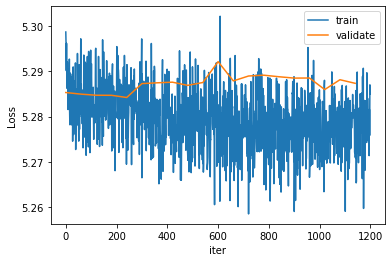

In [26]:
draw_losses(train_loss_values, val_loss_values)

In [27]:
x = np.array([[(i, j) for j in np.arange(200)] for i in np.arange(200)], dtype=np.int64)
x = x.reshape(-1, 2)
model_p = model(x)
model_p = model_p.detach().numpy()
model_p = model_p.reshape((200, 200))

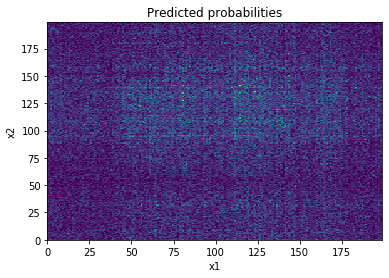

In [28]:
model_ravel = model_p.ravel()
size = 200
pairs = np.array([[(i, j) for j in np.arange(size)] for i in np.arange(size)], dtype=np.int64)
idx = np.random.choice(np.arange(len(model_ravel)), 100000, p=model_ravel / model_ravel.sum())
idx_2d = np.unravel_index(idx, model_p.shape)
samples = pairs[idx_2d]

plt.hist2d(samples[:,0], samples[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.title("Predicted probabilities")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

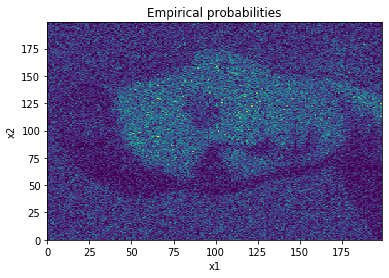

In [29]:
plt.hist2d(data[:,0], data[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.title("Empirical probabilities")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# 2 Two-dimensional data: MADE

In [58]:
class MaskedLinear(torch.nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        
    def forward(self, input, mask):
        return torch.nn.functional.linear(input, mask.float() * self.weight, self.bias)

In [59]:
def get_mask():
    rng = np.random.RandomState(42)
    m = [rng.permutation(400),
             rng.randint(0, 399, size=400)]
    mask1 = torch.tensor((m[0][:,None] <= m[1][None,:]).astype(float)).float()
    mask2 = torch.tensor((m[1][:,None] < m[0][None,:]).astype(float)).float()
    return [mask1, mask2]
        

In [63]:
class MADE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = MaskedLinear(400, 400)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.4)
        self.l2 = MaskedLinear(400, 400)

        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, mask):
        x1, x2 = x[:,0], x[:,1]
        
        one_hot = torch.zeros((x.shape[0], 400), dtype=torch.float).float()
        one_hot[np.arange(x.shape[0]), x1] = 1.0
        one_hot[np.arange(x.shape[0]), 200 + x2] = 1.0

        p = self.l1(one_hot.float(), mask[0])
        p = self.relu(p)
        p = self.drop(p)
        p = self.l2(p, mask[1])
        p = p.view(-1, 2, 200)
        p = self.softmax(p)
        p = torch.gather(p, 2, torch.tensor(x.reshape(len(x), -1, 1))).view(len(x), 2)
        
        return p
    
    def parameters(self):
        return list(self.l1.parameters()) + list(self.relu.parameters()) + list(self.drop.parameters()) + list(self.l2.parameters()) +list(self.softmax.parameters())

In [64]:
model = MADE()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [67]:
val_size = len(validate_data)
train_loss_values = []
val_loss_values = []
        
for epoch in notebook.tqdm(range(20)):
    for batch_data in batches:
        optimizer.zero_grad()
        output = model(batch_data, get_mask())
        loss = Loss(output)
        train_loss_values.append(loss / 2 / batch_size)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(validate_data, get_mask())
        loss = Loss(output)
        val_loss_values.append(loss / 2 / val_size)

with torch.no_grad():
    output = model(test_data, get_mask())
    loss = Loss(output)
    print("Test set loss: " + str(loss.item() / 2 / len(test_data)))

/Users/mariiaeliseeva/Documents/idea-feature-recommendations/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test set loss: 1.61065439453125


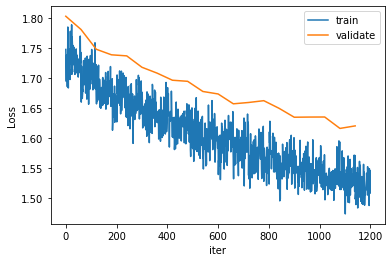

In [68]:
draw_losses(train_loss_values, val_loss_values)

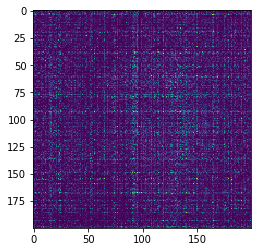

In [70]:
x = np.array([[(i, j) for j in np.arange(200)] for i in np.arange(200)], dtype=np.int64)
x = x.reshape(-1, 2)
model_p = model(x, get_mask())
model_p = model_p.detach().numpy()
model_p = np.array([model_p[i][0] * model_p[i][1] for i in range(len(model_p))])
model_p = model_p.reshape((200, 200))

plt.imshow(model_p)

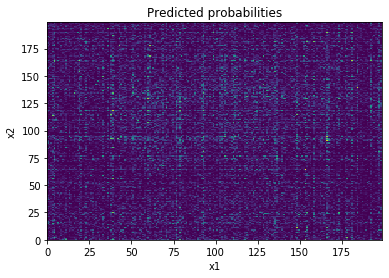

In [71]:
model_ravel = model_p.ravel()
size = 200
pairs = np.array([[(i, j) for j in np.arange(size)] for i in np.arange(size)], dtype=np.int64)
idx = np.random.choice(np.arange(len(model_ravel)), 100000, p=model_ravel / model_ravel.sum())
idx_2d = np.unravel_index(idx, model_p.shape)
samples = pairs[idx_2d]

plt.hist2d(samples[:,0], samples[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.title("Predicted probabilities")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()